# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
drive.mount('/content/drive')

Mounted at /gdrive
Mounted at /content/drive


In [2]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
!tar -xvf drive/MyDrive/datasets_fin.tar > /dev/null

In [3]:
# 필요한 라이브러리를 설치합니다.
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00


## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [76]:
import os
import time
import random
import wandb

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [77]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True


In [78]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [79]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config

CFS={"IMG_SIZE" : 224,
     "LR" : 1e-4,
    'EPOCHS' : 50,
    'BATCH_SIZE' : 32,
    "NUM_WORKERS" : 16,}

wandb.init(project="upstage-DC-project",
           config=CFS,
           name=f"{model_name}, {CFS['LR']}, {CFS['BATCH_SIZE']}"
           )

epoch/train_acc,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch/train_f1,▁▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch/train_loss,██▇▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/train_acc,0.86497
epoch/train_f1,0.85209
epoch/train_loss,0.42029


In [80]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    wandb.log({
    "epoch/train_loss": train_loss,
    "epoch/train_acc": train_acc,
    "epoch/train_f1": train_f1
    })

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [81]:
# augmentation을 위한 transform 코드

trn_transform = A.Compose([
    # 1. 기하학적 변환 (Geometric Transformations)
    A.OneOf([
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.OpticalDistortion(distort_limit=0.2, p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], p=0.8),
    
    # 2. 공간적 변형 (Spatial Transformations)
    A.OneOf([
        A.RandomCrop(height=int(CFS["IMG_SIZE"]*0.9), width=int(CFS["IMG_SIZE"]*0.9), p=0.4),
        A.RandomResizedCrop(height=CFS["IMG_SIZE"], width=CFS["IMG_SIZE"], scale=(0.8, 1.0), p=0.6)
    ], p=1.0),
    
    # 3. 색상 변환 (Color Transformations)
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.CLAHE(clip_limit=4.0, p=0.2)
    ], p=0.7),
    
    # 4. 노이즈 및 블러 (Noise & Blur)
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.MotionBlur(blur_limit=7, p=0.3)
    ], p=0.5),
    
    # 5. 고급 증강 기법 (Advanced Augmentations)
    A.OneOf([
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.5),
        A.RandomSunFlare(src_radius=100, p=0.1),
        A.RandomShadow(num_shadows_lower=1, num_shadows_upper=3, p=0.2)
    ], p=0.5),
    
    # 6. 최종 전처리
    A.Resize(height=CFS["IMG_SIZE"], width=CFS['IMG_SIZE']),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=CFS["IMG_SIZE"], width=CFS['IMG_SIZE']),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [82]:
# Dataset 정의
trn_dataset = ImageDataset(
    "data/train.csv",
    "data/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [83]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=True,
    num_workers=CFS['NUM_WORKERS'],
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=CFS['BATCH_SIZE'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [84]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=CFS['LR'])

In [85]:
for epoch in range(CFS['EPOCHS']):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

Loss: 2.8014: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s]


train_loss: 2.8042
train_acc: 0.0949
train_f1: 0.0698
epoch: 0.0000



Loss: 2.7459: 100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


train_loss: 2.6937
train_acc: 0.2420
train_f1: 0.2108
epoch: 1.0000



Loss: 2.6844: 100%|██████████| 50/50 [00:03<00:00, 13.02it/s]


train_loss: 2.5534
train_acc: 0.3739
train_f1: 0.3313
epoch: 2.0000



Loss: 2.6249: 100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


train_loss: 2.3286
train_acc: 0.4675
train_f1: 0.4048
epoch: 3.0000



Loss: 3.1813: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


train_loss: 2.0777
train_acc: 0.5089
train_f1: 0.4261
epoch: 4.0000



Loss: 3.1663: 100%|██████████| 50/50 [00:03<00:00, 12.99it/s]


train_loss: 1.8250
train_acc: 0.5535
train_f1: 0.4689
epoch: 5.0000



Loss: 2.4776: 100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


train_loss: 1.6266
train_acc: 0.5809
train_f1: 0.4958
epoch: 6.0000



Loss: 2.5803: 100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


train_loss: 1.4547
train_acc: 0.6204
train_f1: 0.5406
epoch: 7.0000



Loss: 1.7421: 100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


train_loss: 1.3129
train_acc: 0.6382
train_f1: 0.5596
epoch: 8.0000



Loss: 1.8152: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


train_loss: 1.1805
train_acc: 0.6713
train_f1: 0.6029
epoch: 9.0000



Loss: 3.2909: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


train_loss: 1.1233
train_acc: 0.6815
train_f1: 0.6230
epoch: 10.0000



Loss: 2.0821: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


train_loss: 0.9981
train_acc: 0.7134
train_f1: 0.6502
epoch: 11.0000



Loss: 1.8420: 100%|██████████| 50/50 [00:03<00:00, 12.81it/s]


train_loss: 0.9458
train_acc: 0.7185
train_f1: 0.6657
epoch: 12.0000



Loss: 3.7698: 100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


train_loss: 0.9307
train_acc: 0.7306
train_f1: 0.6875
epoch: 13.0000



Loss: 1.9027: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


train_loss: 0.8356
train_acc: 0.7624
train_f1: 0.7233
epoch: 14.0000



Loss: 2.0553: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


train_loss: 0.7942
train_acc: 0.7599
train_f1: 0.7214
epoch: 15.0000



Loss: 1.2903: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


train_loss: 0.7539
train_acc: 0.7764
train_f1: 0.7379
epoch: 16.0000



Loss: 1.9166: 100%|██████████| 50/50 [00:03<00:00, 12.85it/s]


train_loss: 0.7183
train_acc: 0.7777
train_f1: 0.7391
epoch: 17.0000



Loss: 2.5568: 100%|██████████| 50/50 [00:03<00:00, 12.69it/s]


train_loss: 0.7393
train_acc: 0.7720
train_f1: 0.7361
epoch: 18.0000



Loss: 1.7903: 100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


train_loss: 0.6834
train_acc: 0.7815
train_f1: 0.7495
epoch: 19.0000



Loss: 1.7018: 100%|██████████| 50/50 [00:03<00:00, 12.79it/s]


train_loss: 0.6539
train_acc: 0.7917
train_f1: 0.7564
epoch: 20.0000



Loss: 1.4348: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


train_loss: 0.6205
train_acc: 0.7955
train_f1: 0.7649
epoch: 21.0000



Loss: 1.6533: 100%|██████████| 50/50 [00:03<00:00, 12.95it/s]


train_loss: 0.6110
train_acc: 0.7943
train_f1: 0.7579
epoch: 22.0000



Loss: 1.5961: 100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


train_loss: 0.6220
train_acc: 0.8051
train_f1: 0.7760
epoch: 23.0000



Loss: 1.4390: 100%|██████████| 50/50 [00:03<00:00, 12.69it/s]


train_loss: 0.5908
train_acc: 0.8013
train_f1: 0.7722
epoch: 24.0000



Loss: 2.3267: 100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


train_loss: 0.6156
train_acc: 0.7987
train_f1: 0.7705
epoch: 25.0000



Loss: 1.8937: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


train_loss: 0.5607
train_acc: 0.8306
train_f1: 0.7976
epoch: 26.0000



Loss: 2.1571: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


train_loss: 0.5647
train_acc: 0.8204
train_f1: 0.7955
epoch: 27.0000



Loss: 1.9331: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


train_loss: 0.5486
train_acc: 0.8236
train_f1: 0.8011
epoch: 28.0000



Loss: 1.5006: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


train_loss: 0.5036
train_acc: 0.8363
train_f1: 0.8166
epoch: 29.0000



Loss: 1.0542: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


train_loss: 0.5315
train_acc: 0.8178
train_f1: 0.7906
epoch: 30.0000



Loss: 1.6495: 100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


train_loss: 0.4799
train_acc: 0.8433
train_f1: 0.8228
epoch: 31.0000



Loss: 2.6403: 100%|██████████| 50/50 [00:03<00:00, 12.71it/s]


train_loss: 0.5477
train_acc: 0.8268
train_f1: 0.8079
epoch: 32.0000



Loss: 2.4535: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


train_loss: 0.5013
train_acc: 0.8439
train_f1: 0.8257
epoch: 33.0000



Loss: 1.9675: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


train_loss: 0.4775
train_acc: 0.8433
train_f1: 0.8234
epoch: 34.0000



Loss: 1.3168: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


train_loss: 0.4474
train_acc: 0.8439
train_f1: 0.8284
epoch: 35.0000



Loss: 1.8799: 100%|██████████| 50/50 [00:03<00:00, 12.95it/s]


train_loss: 0.4764
train_acc: 0.8414
train_f1: 0.8197
epoch: 36.0000



Loss: 2.9368: 100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


train_loss: 0.4552
train_acc: 0.8643
train_f1: 0.8510
epoch: 37.0000



Loss: 1.9360: 100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


train_loss: 0.4732
train_acc: 0.8395
train_f1: 0.8279
epoch: 38.0000



Loss: 1.1440: 100%|██████████| 50/50 [00:03<00:00, 12.83it/s]


train_loss: 0.4083
train_acc: 0.8701
train_f1: 0.8570
epoch: 39.0000



Loss: 1.7729: 100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


train_loss: 0.4357
train_acc: 0.8605
train_f1: 0.8482
epoch: 40.0000



Loss: 1.6173: 100%|██████████| 50/50 [00:03<00:00, 12.87it/s]


train_loss: 0.4075
train_acc: 0.8771
train_f1: 0.8665
epoch: 41.0000



Loss: 2.2064: 100%|██████████| 50/50 [00:03<00:00, 12.81it/s]


train_loss: 0.4574
train_acc: 0.8541
train_f1: 0.8393
epoch: 42.0000



Loss: 1.0542: 100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


train_loss: 0.4155
train_acc: 0.8611
train_f1: 0.8466
epoch: 43.0000



Loss: 1.4884: 100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


train_loss: 0.3976
train_acc: 0.8732
train_f1: 0.8611
epoch: 44.0000



Loss: 0.9229: 100%|██████████| 50/50 [00:03<00:00, 12.89it/s]


train_loss: 0.3888
train_acc: 0.8618
train_f1: 0.8516
epoch: 45.0000



Loss: 0.9033: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


train_loss: 0.3844
train_acc: 0.8701
train_f1: 0.8579
epoch: 46.0000



Loss: 1.3084: 100%|██████████| 50/50 [00:03<00:00, 12.77it/s]


train_loss: 0.3736
train_acc: 0.8809
train_f1: 0.8735
epoch: 47.0000



Loss: 1.8882: 100%|██████████| 50/50 [00:03<00:00, 12.87it/s]


train_loss: 0.3896
train_acc: 0.8822
train_f1: 0.8690
epoch: 48.0000



Loss: 1.2812: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s]

train_loss: 0.3736
train_acc: 0.8732
train_f1: 0.8635
epoch: 49.0000



# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [86]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:26<00:00,  3.79it/s]


In [87]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [88]:
sample_submission_df = pd.read_csv("data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [89]:
pred_df.to_csv("pred.csv", index=False)

In [90]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,2


## EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
## EDA
df = pd.read_csv("./data/train.csv")
df2 = pd.read_csv("./data/meta.csv")

# 1. 데이터 기본 정보 확인
print("="*50)
print("1. 데이터 기본 정보")
print("="*50)
print(f"전체 샘플 수: {len(df)}")
print(f"고유 클래스 수: {df['target'].nunique()}")

# 2. 클래스 분포 분석
print("\n" + "="*50)
print("2. 클래스 분포 분석")
print("="*50)
class_dist = pd.merge(df['target'].value_counts().sort_index(),df2,on='target')
print(class_dist.to_string())

1. 데이터 기본 정보
전체 샘플 수: 1570
고유 클래스 수: 17

2. 클래스 분포 분석
    target  count                                             class_name
0        0    100                                         account_number
1        1     46  application_for_payment_of_pregnancy_medical_expenses
2        2    100                                          car_dashboard
3        3    100                confirmation_of_admission_and_discharge
4        4    100                                              diagnosis
5        5    100                                         driver_lisence
6        6    100                                  medical_bill_receipts
7        7    100                         medical_outpatient_certificate
8        8    100                                       national_id_card
9        9    100                                               passport
10      10    100                                   payment_confirmation
11      11    100                                 pharmaceutical_recei

In [ ]:
plt.imshow()

,target,class_name
0,0,account_number
1,1,application_for_payment_of_pregnancy_medical_e...
2,2,car_dashboard
3,3,confirmation_of_admission_and_discharge
4,4,diagnosis
5,5,driver_lisence
6,6,medical_bill_receipts
7,7,medical_outpatient_certificate
8,8,national_id_card
9,9,passport


<Axes: >

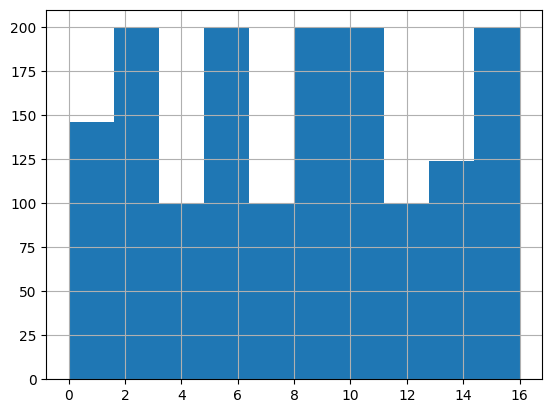

In [ ]:
df['target'].hist()